In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras.layers import GaussianNoise

# Initialize rng
rng = np.random.default_rng(2022)

In [3]:
batch_size = 32 # This is a tunable hyperparameter
input_shape = (128, 128) # note we are reducing the size of the image
data_dir = '/content/drive/MyDrive/HW2/split_archive/'
train_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'train'),
                                                       seed=rng.integers(500000),
                                                       image_size=input_shape,
                                                       color_mode='grayscale',
                                                       batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'val'),
                                                     seed=rng.integers(500000),
                                                     image_size=input_shape,
                                                     color_mode='grayscale',
                                                     batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'test'),
                                                      seed=rng.integers(500000),
                                                      image_size=input_shape,
                                                      color_mode='grayscale',
                                                      batch_size=batch_size)

Found 3924 files belonging to 2 classes.
Found 841 files belonging to 2 classes.
Found 841 files belonging to 2 classes.


In [4]:
# Noise layer to add Gaussian noise
# This layer adds zero-mean Gussian noise with the given standard deviation
noise_layer = GaussianNoise(0.2)

# API to change data from X, y to X_noisy, X_clean (disregard class variable)
def change_inputs_outputs(images, labels):
  # Reshape images to shape=128x128; these are clean images, i.e., output
  X_clean = tf.image.resize(images, list(input_shape))
  # Add noise to create synthetic input imaages
  X_noisy = noise_layer(X_clean)
  # The function must return data in theutpu format - input, ot
  return X_noisy/255.0, X_clean/255.0

In [5]:
# Map train, validation, and output sets to the desired input, output configuration using the API we created
train_ds = train_ds.map(change_inputs_outputs)
val_ds = val_ds.map(change_inputs_outputs)
test_ds = test_ds.map(change_inputs_outputs)


In [6]:
print(len(test_ds))
print(train_ds)

27
<_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


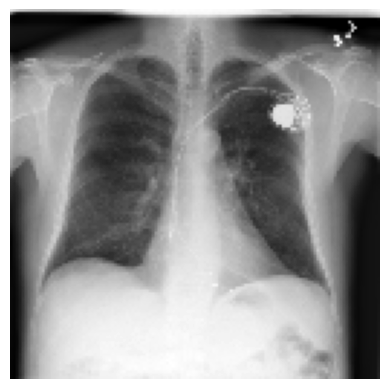

In [7]:
import matplotlib.pyplot as plt

# Assuming train_ds is a TensorFlow dataset mapped with change_inputs_outputs
for batch in train_ds:
    first_image = batch[0][0]  # Get the first image from the first batch
    plt.imshow(first_image.numpy().reshape(128, 128), cmap='gray')  # Reshape and display the image
    plt.axis('off')  # Turn off axis for better visualization
    plt.show()
    break  # Break after displaying the first image


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers

# Start your solution below

#(a) Design and train a denoising autoencoder with only fully-connected layers. Your encoder and decoder must have no less than 2 hidden layers. Train the model with two different loss functions,
## i. L-2 loss, i.e., MSE
## ii. Huber loss

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

latent_dim = 64
input_shape=(128, 128)

input_img = keras.Input(shape=(128,128,))
encoded = Dense(256, activation='relu')(tf.keras.layers.Flatten()(input_img))
encoded = Dense(latent_dim, activation='relu')(encoded)


# Decoder
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(128*128, activation='sigmoid')(decoded)
decoded = Reshape((128, 128))(decoded)


# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)
autoencoder2 = keras.Model(input_img, decoded)

In [10]:
from tensorflow import keras
loss_function = keras.losses.Huber()

# Create autoencoder model
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=MeanSquaredError())

# Create autoencoder model
autoencoder2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.Huber())

In [18]:
# Early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=0,
                   patience=10,
                   restore_best_weights=True)


history = autoencoder.fit(train_ds,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          callbacks=[es],
                          validation_data=test_ds)

Epoch 1/50
123/123 [==============================] - 16s 109ms/step - loss: 0.0064 - val_loss: 0.0071
Epoch 2/50
123/123 [==============================] - 14s 106ms/step - loss: 0.0062 - val_loss: 0.0070
Epoch 3/50
123/123 [==============================] - 14s 104ms/step - loss: 0.0062 - val_loss: 0.0070
Epoch 4/50
123/123 [==============================] - 14s 105ms/step - loss: 0.0063 - val_loss: 0.0070
Epoch 5/50
123/123 [==============================] - 14s 105ms/step - loss: 0.0062 - val_loss: 0.0071
Epoch 6/50
123/123 [==============================] - 14s 106ms/step - loss: 0.0062 - val_loss: 0.0071
Epoch 7/50
123/123 [==============================] - 14s 106ms/step - loss: 0.0061 - val_loss: 0.0074
Epoch 8/50
123/123 [==============================] - 14s 107ms/step - loss: 0.0061 - val_loss: 0.0069
Epoch 9/50
123/123 [==============================] - 14s 105ms/step - loss: 0.0060 - val_loss: 0.0069
Epoch 10/50
123/123 [==============================] - 14s 104ms/step - l

In [12]:
# Early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=0,
                   patience=10,
                   restore_best_weights=True)

# Train
history2 = autoencoder2.fit(train_ds,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          callbacks=[es],
                          validation_data=test_ds)

Epoch 1/50
123/123 [==============================] - 140s 1s/step - loss: 0.0187 - val_loss: 0.0135
Epoch 2/50
123/123 [==============================] - 15s 111ms/step - loss: 0.0114 - val_loss: 0.0094
Epoch 3/50
123/123 [==============================] - 14s 111ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 4/50
123/123 [==============================] - 14s 111ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 5/50
123/123 [==============================] - 14s 111ms/step - loss: 0.0071 - val_loss: 0.0074
Epoch 6/50
123/123 [==============================] - 14s 111ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 7/50
123/123 [==============================] - 14s 108ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 8/50
123/123 [==============================] - 14s 108ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 9/50
123/123 [==============================] - 14s 104ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 10/50
123/123 [==============================] - 14s 108ms/step - los

In [16]:
# plot learning curves
def summarize_diagnostics(history):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    # plot loss
    ax.set_title('Loss Curves', fontsize=20)
    ax.plot(history.history['loss'], label='train')
    ax.plot(history.history['val_loss'], label='test')
    ax.set_xlabel('Epochs', fontsize=15)
    ax.set_ylabel('Loss', fontsize=15)
    ax.legend(fontsize=15)

27/27 [==============================] - 3s 67ms/step


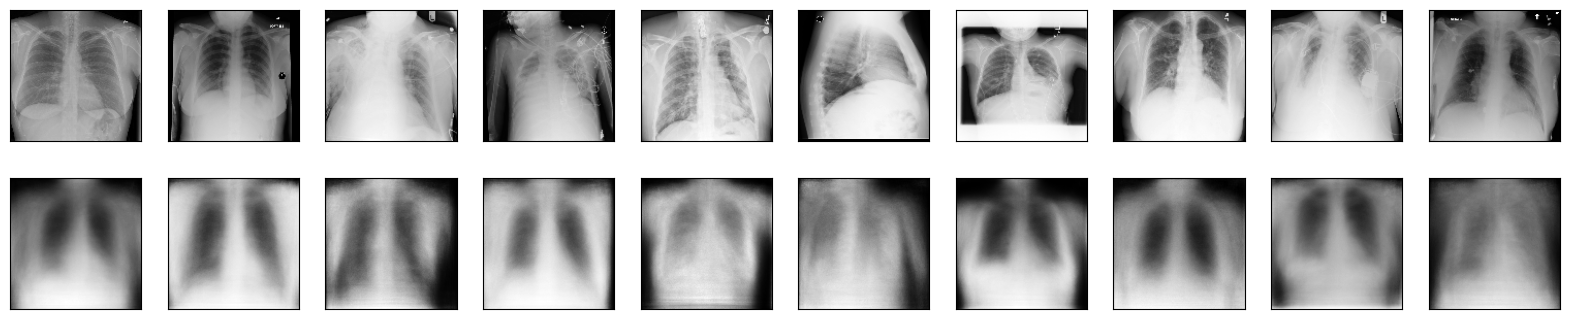

In [19]:
decoded_imgs = autoencoder.predict(test_ds)

plt.figure(figsize=(20, 4))
for i, (original_batch, _) in enumerate(test_ds.take(n)):
    # Take the first image from the batch
    original_image = original_batch[0].numpy()

    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_image.reshape(128, 128), cmap='gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128), cmap='gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

27/27 [==============================] - 3s 65ms/step


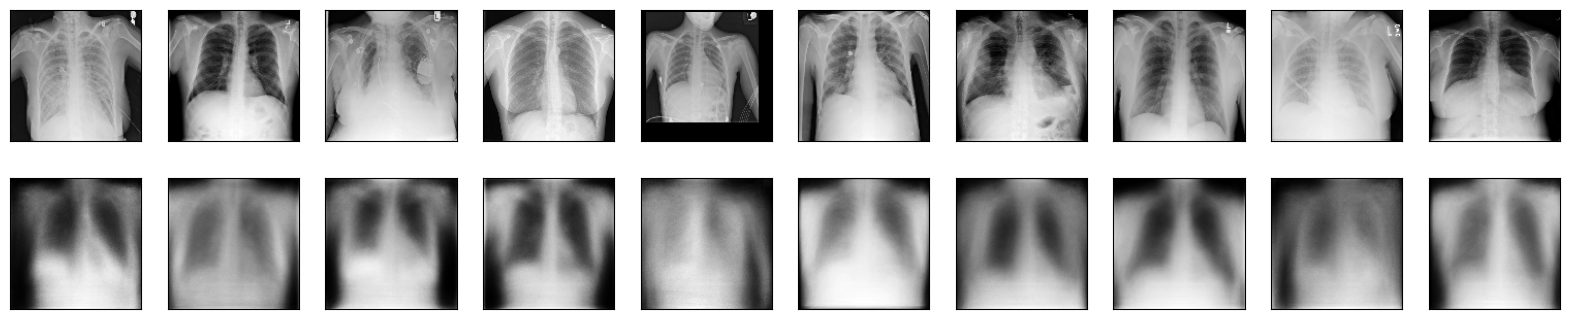

In [15]:
decoded_imgs2 = autoencoder2.predict(test_ds)
n = 10
plt.figure(figsize=(20, 4))
for i, (original_batch, _) in enumerate(test_ds.take(n)):
    # Take the first image from the batch
    original_image = original_batch[0].numpy()

    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_image.reshape(128, 128), cmap='gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs2[i].reshape(128, 128), cmap='gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()




## b. Since we are denoising images, you might have realized that it is more prudent to use convolutional filters to design our denoising autoencoder. Design and train a convolutional denoising autoencoder, i.e., an autoencoder with layers you would find in CNNs, e.g., conv layers, maxpooling, and transposed conv layers. Train with the two different loss functions as above.

In [62]:
from keras.layers import Input, Dense, Reshape, Conv2D, MaxPooling2D, UpSampling2D
input_shape=(128, 128)


In [72]:
train_ds2 = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'train'),
                                                       seed=rng.integers(500000),
                                                       image_size=input_shape,
                                                       color_mode='grayscale',
                                                       batch_size=batch_size,
                                                       label_mode=None)
val_ds2 = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'val'),
                                                     seed=rng.integers(500000),
                                                     image_size=input_shape,
                                                     color_mode='grayscale',
                                                     label_mode=None,
                                                     batch_size=batch_size)
test_ds2 = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'test'),
                                                      seed=rng.integers(500000),
                                                      image_size=input_shape,
                                                      color_mode='grayscale',
                                                      label_mode=None,
                                                      batch_size=batch_size)

Found 3924 files belonging to 1 classes.
Found 841 files belonging to 1 classes.
Found 841 files belonging to 1 classes.


In [75]:
# API to change data from X, y to X_noisy, X_clean (disregard class variable)
def change_inputs_outputs_new(images):
  # Reshape images to shape=128x128; these are clean images, i.e., output
  X_clean = tf.image.resize(images, list(input_shape))
  # Add noise to create synthetic input imaages
  X_noisy = noise_layer(X_clean)
  # The function must return data in theutpu format - input, ot
  return X_noisy/255.0, X_clean/255.0

In [77]:
# Map train, validation, and output sets to the desired input, output configuration using the API we created
X_train_2 = train_ds2.map(change_inputs_outputs_new)
X_test_2 = test_ds2.map(change_inputs_outputs_new)


X_noisy shape: (32, 128, 128, 1)
X_clean shape: (32, 128, 128, 1)


In [78]:
def get_noisy_image(noisy_image, clean_image):
    return noisy_image

def get_clean_image(noisy_image, clean_image):
    return clean_image


noisy_dataset = X_train_2.map(get_noisy_image)
clean_dataset = X_train_2.map(get_clean_image)

noisy_dataset2 = X_test_2.map(get_noisy_image)
clean_dataset2 = X_test_2.map(get_clean_image)

X_train = tf.concat(list(noisy_dataset), axis=0).numpy()
X_clean = tf.concat(list(clean_dataset), axis=0).numpy()

X_test = tf.concat(list(noisy_dataset2), axis=0).numpy()
X_test_clean = tf.concat(list(clean_dataset2), axis=0).numpy()

In [79]:
X_train = np.reshape(X_train, (len(X_train), 128, 128, 1))
X_test = np.reshape(X_test, (len(X_test), 128, 128, 1))

X_clean = np.reshape(X_clean, (len(X_clean), 128, 128, 1))
X_test_clean = np.reshape(X_test_clean, (len(X_test_clean), 128, 128, 1))

In [80]:
X_train

array([[[[0.        ],
         [0.        ],
         [0.38921568],
         ...,
         [0.46372548],
         [0.56666666],
         [0.5627451 ]],

        [[0.        ],
         [0.        ],
         [0.06568628],
         ...,
         [0.03431373],
         [0.10490196],
         [0.2882353 ]],

        [[0.        ],
         [0.        ],
         [0.00392157],
         ...,
         [0.00784314],
         [0.01176471],
         [0.05392157]],

        ...,

        [[0.28529412],
         [0.12254902],
         [0.03137255],
         ...,
         [0.02156863],
         [0.08333334],
         [0.30980393]],

        [[0.40980393],
         [0.2637255 ],
         [0.14019608],
         ...,
         [0.05392157],
         [0.14901961],
         [0.35196078]],

        [[0.6852941 ],
         [0.5686275 ],
         [0.46764705],
         ...,
         [0.14705883],
         [0.27941176],
         [0.4598039 ]]],


       [[[0.01176471],
         [0.01176471],
         [0.01

In [83]:
latent_dim = 64
input_shape = (128, 128, 1)

input_img = keras.Input(shape=input_shape)

# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# This model maps an input to its reconstruction
autoencoder3 = keras.Model(input_img, decoded)
autoencoder4 = keras.Model(input_img, decoded)

# Create autoencoder model
autoencoder3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=MeanSquaredError())

# Create autoencoder model
autoencoder4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.Huber())


In [84]:
# Early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=0,
                   patience=10,
                   restore_best_weights=True)

# Train
history3 = autoencoder3.fit(X_train, X_train,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          callbacks=[es],
                          validation_data=test_ds)

Epoch 1/50
123/123 [==============================] - 12s 37ms/step - loss: 0.0549 - val_loss: 0.0378
Epoch 2/50
123/123 [==============================] - 4s 33ms/step - loss: 0.0183 - val_loss: 0.0104
Epoch 3/50
123/123 [==============================] - 4s 35ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 4/50
123/123 [==============================] - 4s 32ms/step - loss: 0.0077 - val_loss: 0.0073
Epoch 5/50
123/123 [==============================] - 4s 32ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 6/50
123/123 [==============================] - 4s 34ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 7/50
123/123 [==============================] - 4s 33ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 8/50
123/123 [==============================] - 4s 32ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 9/50
123/123 [==============================] - 4s 32ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 10/50
123/123 [==============================] - 4s 34ms/step - loss: 0.0048 - val_l

27/27 [==============================] - 0s 2ms/step


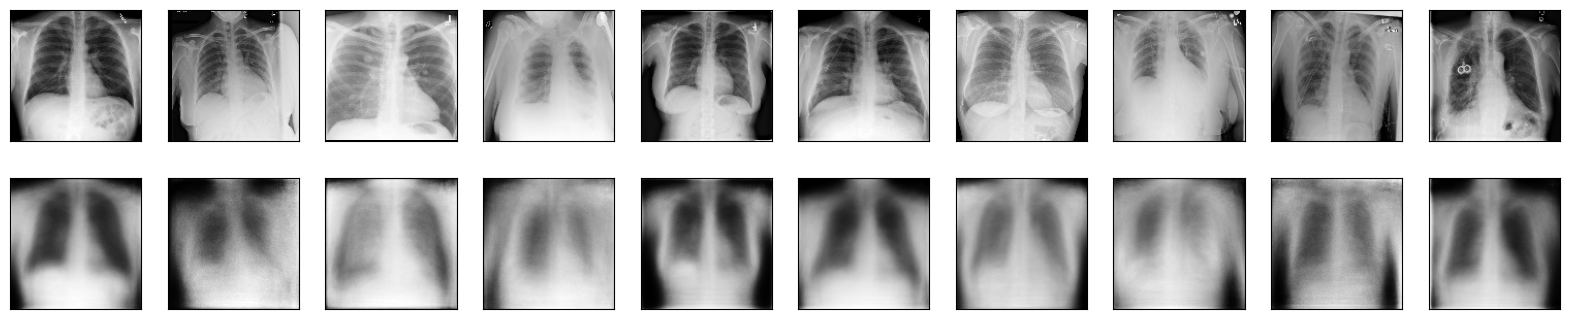

In [91]:
decoded_imgs3 = autoencoder.predict(X_test_clean)

n = 10 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test_clean[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs3[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [85]:
# Early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=0,
                   patience=10,
                   restore_best_weights=True)

# Train
history4 = autoencoder4.fit(X_train, X_train,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          callbacks=[es],
                          validation_data=test_ds)

Epoch 1/50
123/123 [==============================] - 6s 37ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 2/50
123/123 [==============================] - 4s 35ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 3/50
123/123 [==============================] - 5s 39ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 4/50
123/123 [==============================] - 4s 36ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5/50
123/123 [==============================] - 4s 36ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/50
123/123 [==============================] - 5s 38ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 7/50
123/123 [==============================] - 4s 36ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/50
123/123 [==============================] - 4s 36ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/50
123/123 [==============================] - 5s 37ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/50
123/123 [==============================] - 5s 37ms/step - loss: 0.0013 - val_lo

27/27 [==============================] - 0s 2ms/step


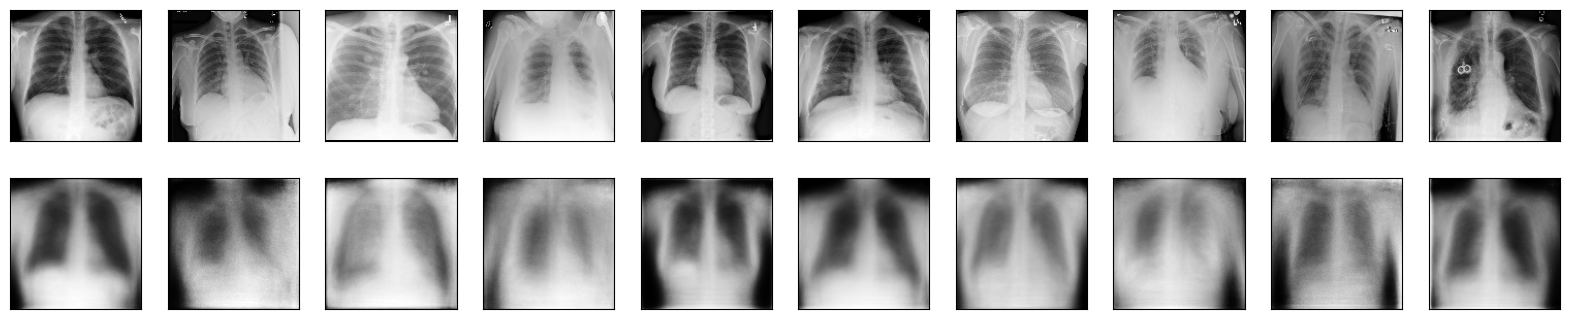

In [90]:
decoded_imgs4 = autoencoder.predict(X_test_clean)

n = 10 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test_clean[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs4[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# This was a really interesting homework assignment!

The best denoiser was convulation AE with Huber, and that was easily the slowest of the models. Below are the first 10 images with both the conv2d models with different loss functions. This is likely due to not training the mse models enough. 50 epochs was not nearly enough for those models but was perfect for the conv models.

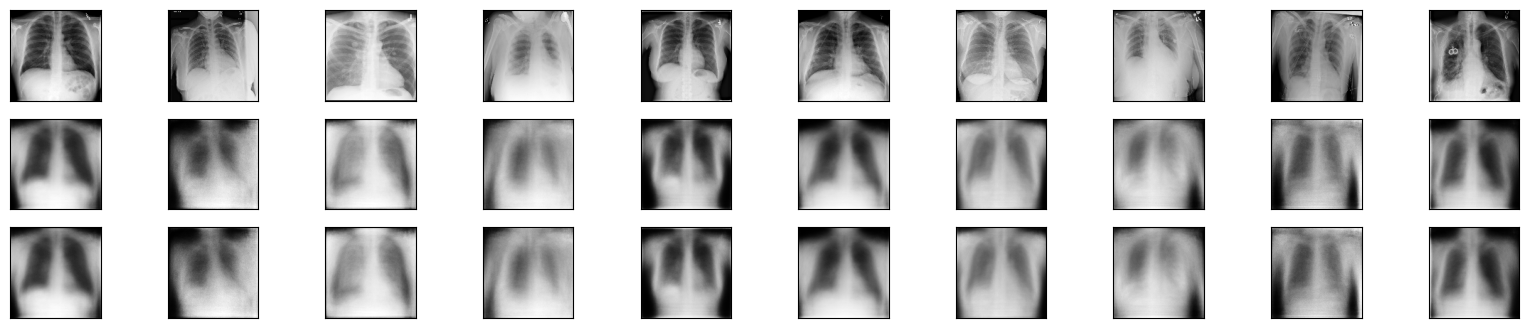

In [104]:
n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(X_test_clean[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction (1st model)
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs3[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction (2nd model)
    ax = plt.subplot(3, n, i + 2 * n)
    plt.imshow(decoded_imgs4[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


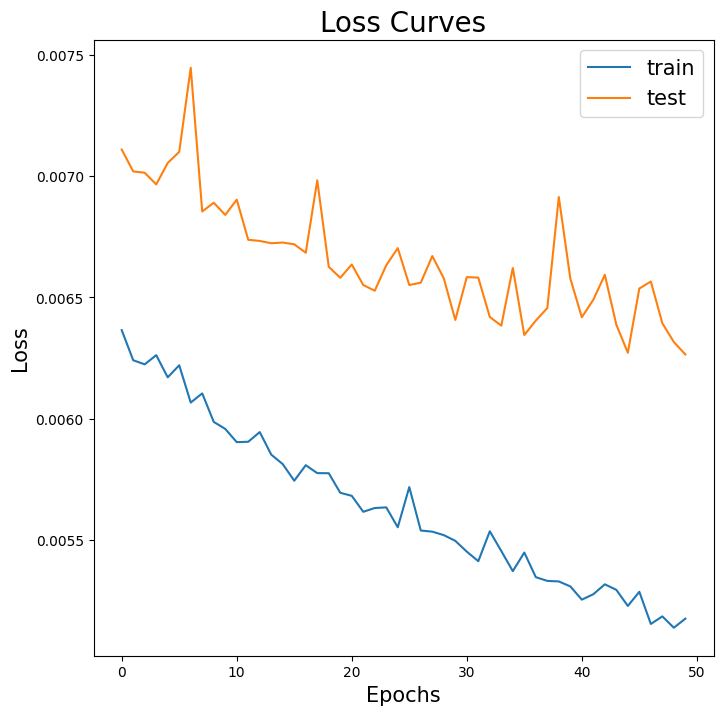

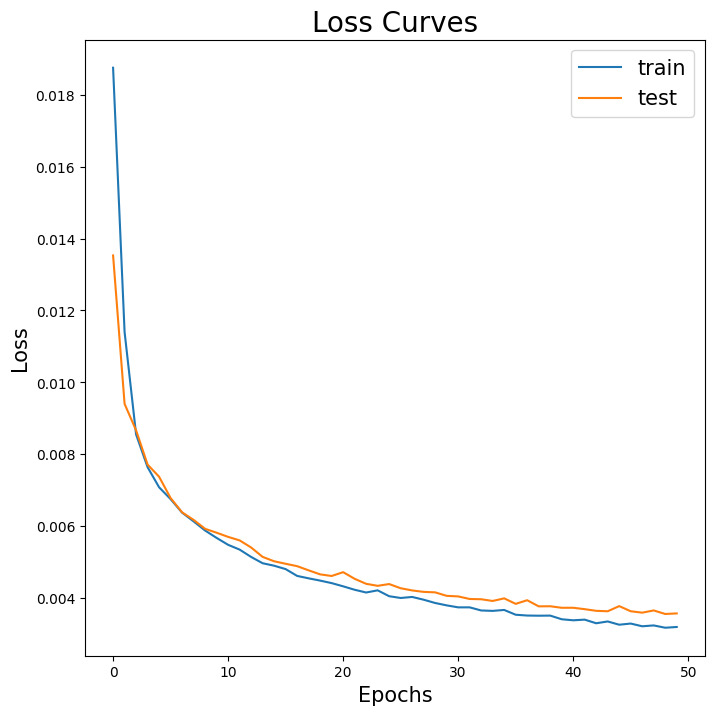

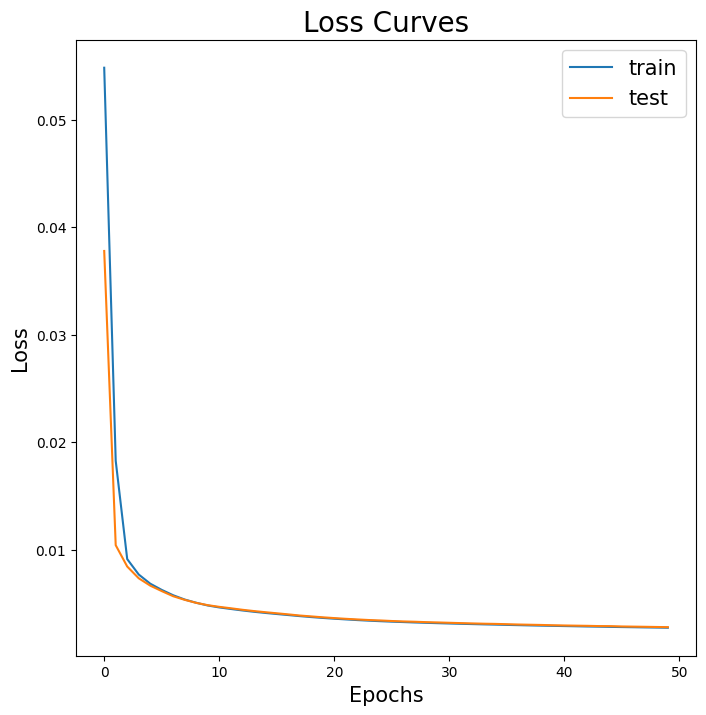

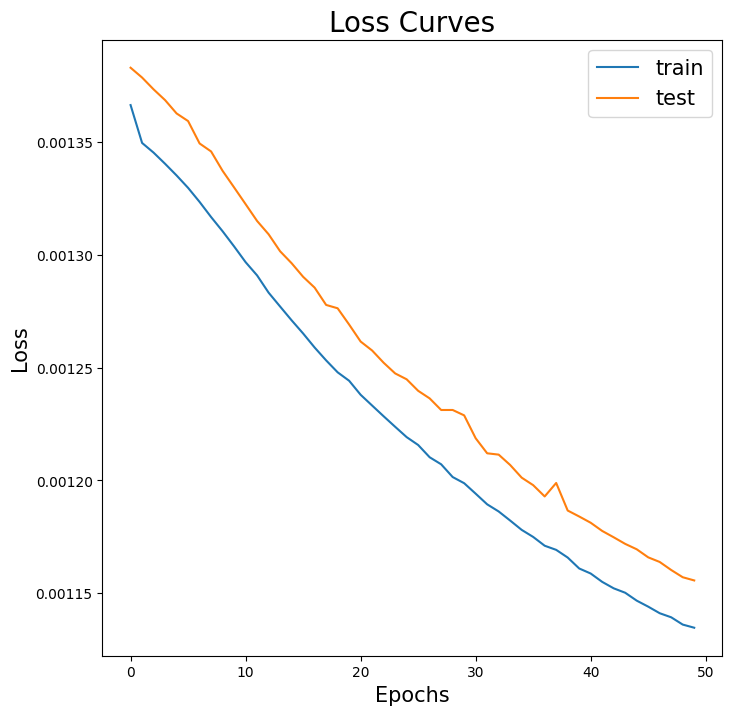

In [105]:
summarize_diagnostics(history)
summarize_diagnostics(history2)
summarize_diagnostics(history3)
summarize_diagnostics(history4)